# Predict Risk of CHD in 10 years

### Libraries

In [4]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px

import xgboost as xgb  
from xgboost import XGBClassifier, cv  
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.metrics import (accuracy_score, precision_score, recall_score,  
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)  

from collections import Counter  
import shap  
import warnings  

import ipywidgets as widgets  
from IPython.display import display, clear_output, HTML  

### Loading the Framingham Dataset (source: https://www.kaggle.com/datasets/shreyjain601/framingham-heart-study/data)

In [6]:
# Load dataset from CSV, setting the first row as header and replacing first column of randomID with index
df = pd.read_csv('Framingham Dataset.csv', 
                 header=0, #set first row as headers
                 index_col=0, #use first row as index instead of randomIDs provided
                 encoding='utf-8',
                 na_values=['NA', '?']
                )
# test data 
#print(df.head())

## EDA

### General Analysis

In [9]:
# rows and columns
df.shape

(11627, 38)

In [10]:
#data info 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11627 entries, 2448 to 9999312
Data columns (total 38 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEX       11627 non-null  int64  
 1   TOTCHOL   11218 non-null  float64
 2   AGE       11627 non-null  int64  
 3   SYSBP     11627 non-null  float64
 4   DIABP     11627 non-null  float64
 5   CURSMOKE  11627 non-null  int64  
 6   CIGPDAY   11548 non-null  float64
 7   BMI       11575 non-null  float64
 8   DIABETES  11627 non-null  int64  
 9   BPMEDS    11034 non-null  float64
 10  HEARTRTE  11621 non-null  float64
 11  GLUCOSE   10187 non-null  float64
 12  educ      11332 non-null  float64
 13  PREVCHD   11627 non-null  int64  
 14  PREVAP    11627 non-null  int64  
 15  PREVMI    11627 non-null  int64  
 16  PREVSTRK  11627 non-null  int64  
 17  PREVHYP   11627 non-null  int64  
 18  TIME      11627 non-null  int64  
 19  PERIOD    11627 non-null  int64  
 20  HDLC      3027 non-null   fl

In [11]:
#Establish an understanding of null values in data (less than 5% of data is null)
null_rows = df.isnull().sum()
null_cells = null_rows.sum()
total_cells = np.product(df.shape) 
percent_missing = (null_cells / total_cells) *100
print("Missing cells:", null_cells) 
print("Total cells:", total_cells)
print("Percent missing cells:", round((percent_missing),2), end ="%")



Missing cells: 20075
Total cells: 441826
Percent missing cells: 4.54%

In [12]:
# null values per column
df.isnull().sum()

SEX            0
TOTCHOL      409
AGE            0
SYSBP          0
DIABP          0
CURSMOKE       0
CIGPDAY       79
BMI           52
DIABETES       0
BPMEDS       593
HEARTRTE       6
GLUCOSE     1440
educ         295
PREVCHD        0
PREVAP         0
PREVMI         0
PREVSTRK       0
PREVHYP        0
TIME           0
PERIOD         0
HDLC        8600
LDLC        8601
DEATH          0
ANGINA         0
HOSPMI         0
MI_FCHD        0
ANYCHD         0
STROKE         0
CVD            0
HYPERTEN       0
TIMEAP         0
TIMEMI         0
TIMEMIFC       0
TIMECHD        0
TIMESTRK       0
TIMECVD        0
TIMEDTH        0
TIMEHYP        0
dtype: int64

In [13]:
# Conform SEX column to standard binary format. 0 male, 1 female 
df.replace({'SEX': 1} , 0,  inplace=True)
df.replace({'SEX': 2} , 1,  inplace=True)

In [14]:
# Test to ensures change (pass)
print(df.loc[:,['SEX']].head(5))

        SEX
RANDID     
2448      0
2448      0
6238      1
6238      1
6238      1


In [15]:
#List of all columns in dataset 
print(df.columns)

Index(['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE', 'CIGPDAY', 'BMI',
       'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ', 'PREVCHD',
       'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD', 'HDLC',
       'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD', 'STROKE',
       'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')


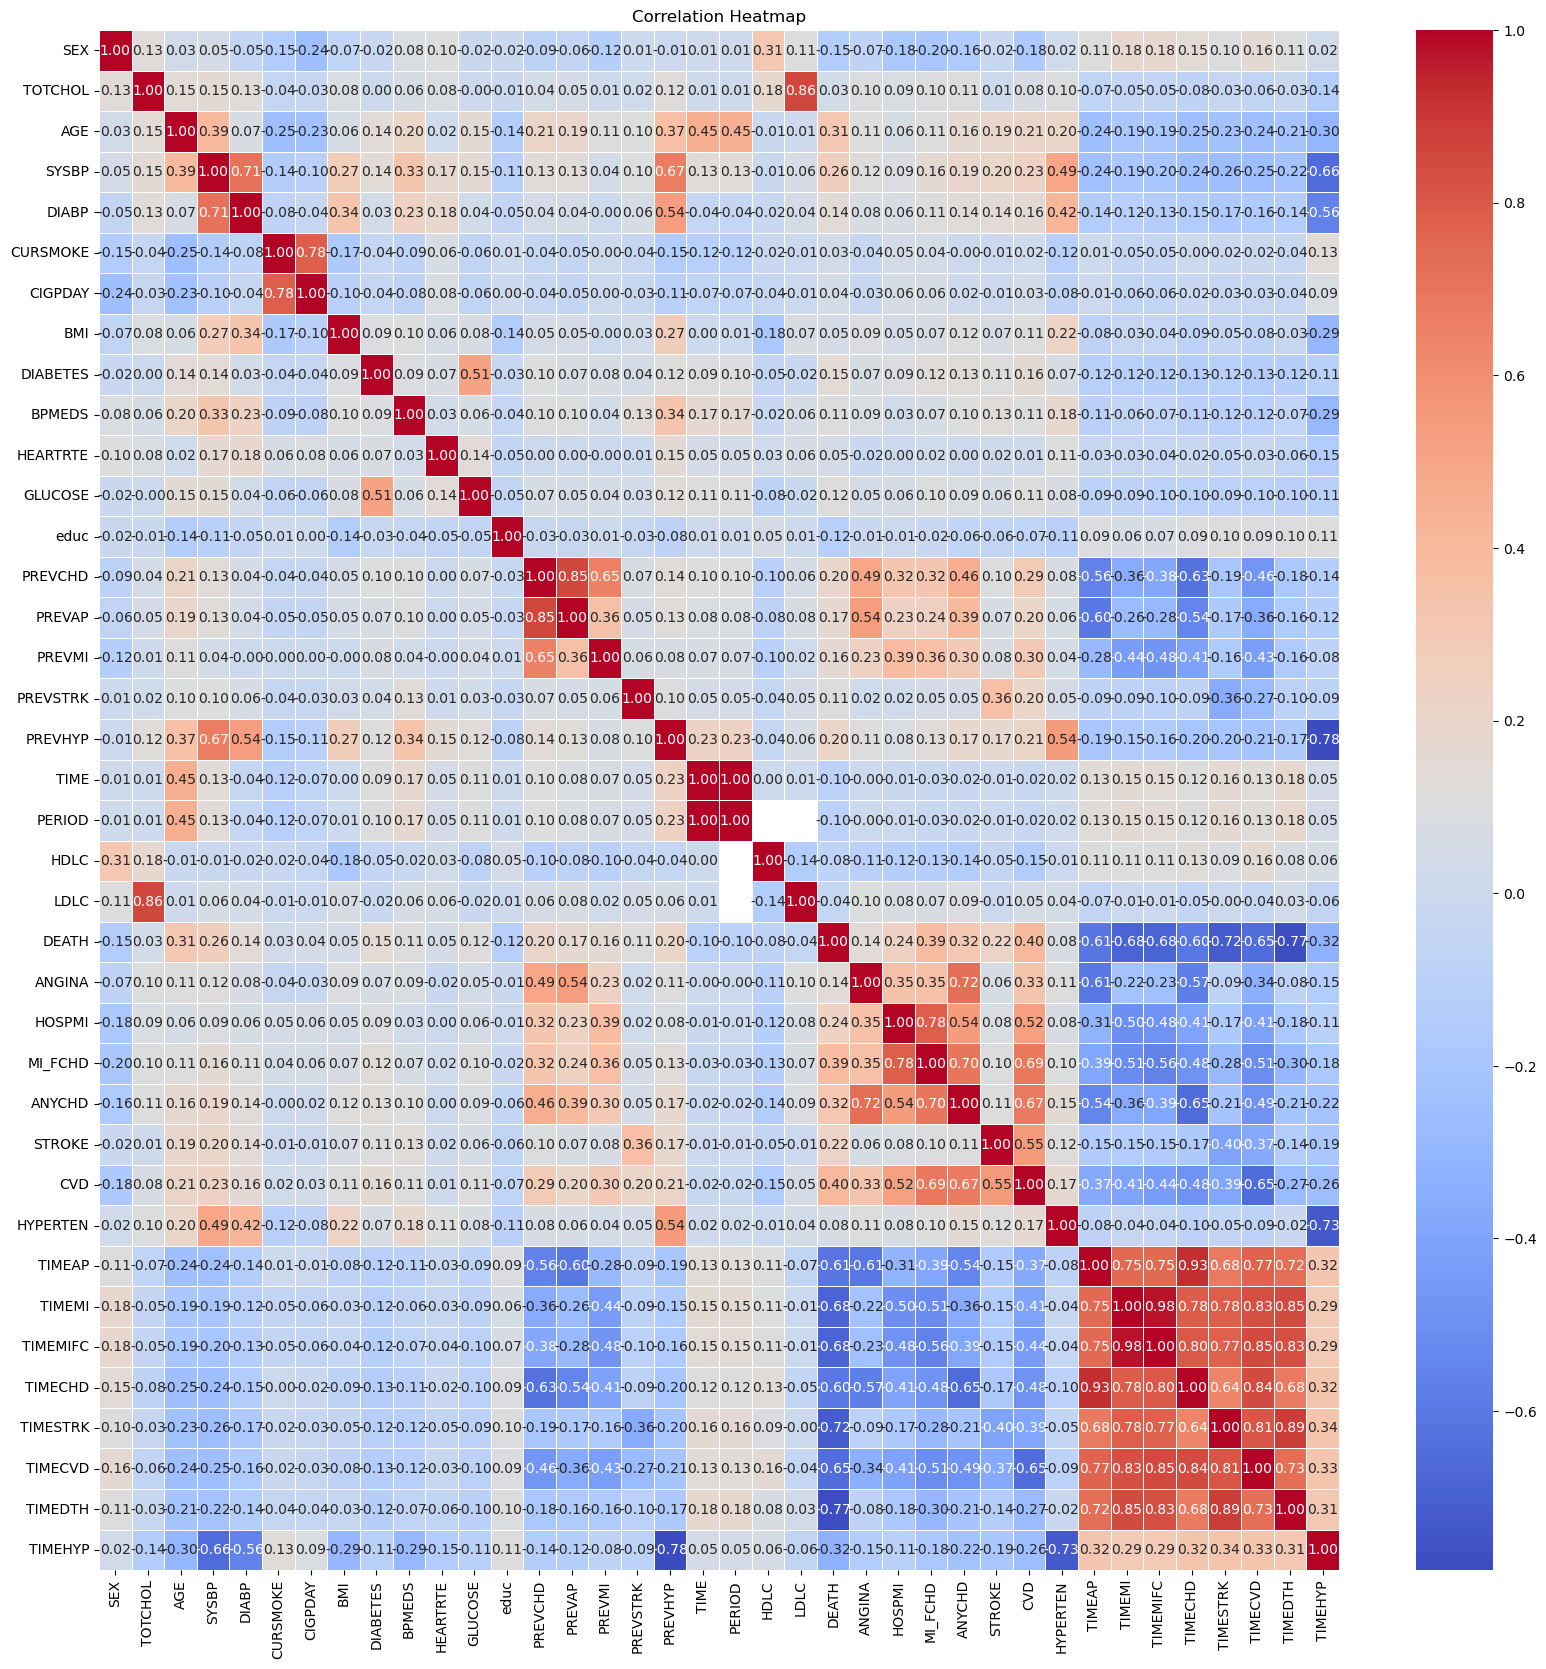

In [16]:
#Corellation matrix to check for redundancy 
correlation_matrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### X/Y Split and Drop Columns 

In [18]:
#Establish columns to drop from features due to redundancy/unimportant/data leak
dropped_columns = ['HDLC', 'LDLC', 'DEATH', 'TIMEDTH', 'TIMEMI', 'TIMESTRK', 'TIMEAP', 
                   'TIMEMIFC', 'TIMECHD', 'TIMECVD', 'TIMEHYP', 'TIME', 'CVD', 'PREVAP', 'PERIOD',
                   'CURSMOKE','SYSBP', 'PREVMI', 'ANYCHD', 'HOSPMI', 'MI_FCHD', 'PREVHYP' , 'GLUCOSE']

In [19]:
#Split Data into features and target 
features = df.copy()
CHD = df.ANYCHD

In [20]:
#print(features.columns) # test 
# Drop columns from features 
features.drop(dropped_columns, axis=1, inplace=True)
#test
#print(features.columns)


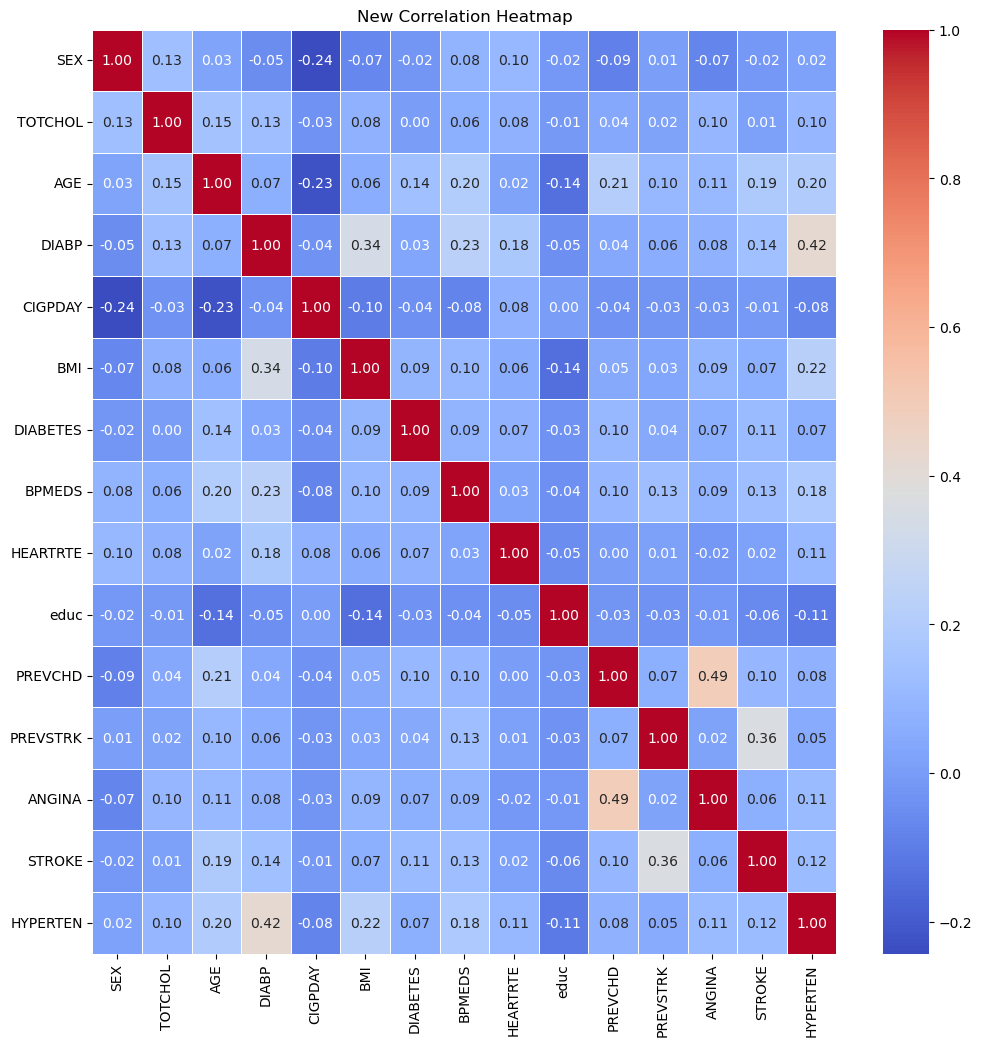

In [21]:
#Check new correlation heat map. (No correlation > .50)
correlation_matrix = features.corr()
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("New Correlation Heatmap")
plt.show()

### Distributions 


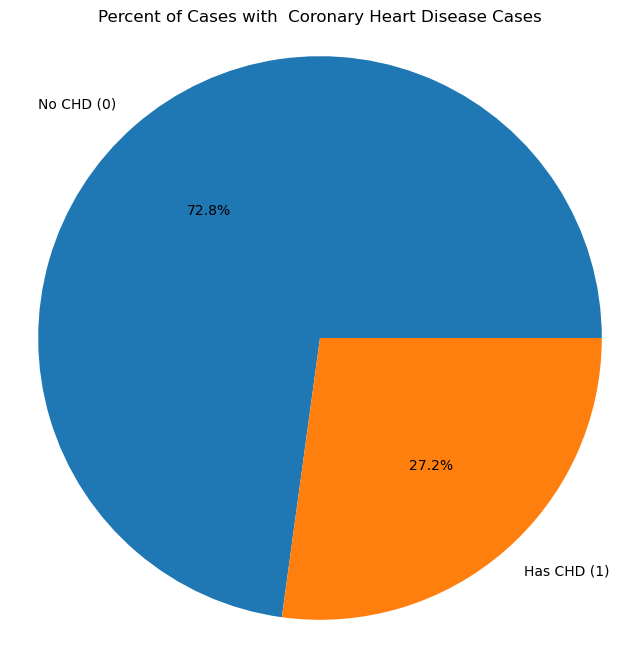

In [23]:
#Pie chart to determine CHD percentages of outcomes
chd_counts = df['ANYCHD'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(chd_counts, labels=['No CHD (0)', 'Has CHD (1)'], autopct='%1.1f%%')
plt.title('Percent of Cases with  Coronary Heart Disease Cases')
plt.axis('equal')  
plt.show()


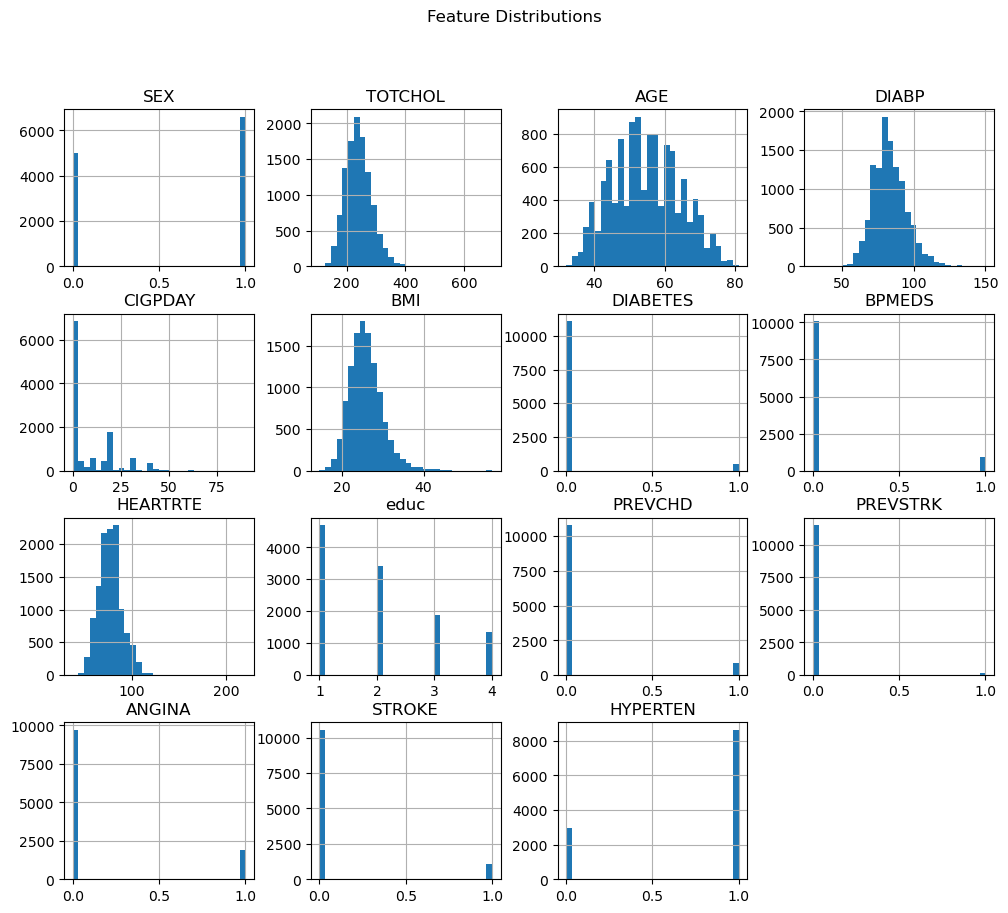

In [24]:
#Examinaiton of Dstributuon of Features 

features.hist(figsize=(12,10), bins=30)
plt.suptitle('Feature Distributions')
plt.show()

## Preprocessing for Training

### Train - Test Split 

In [27]:
#Train-Test Split 
features_train, features_test, CHD_train, CHD_test = train_test_split(features, CHD, test_size=0.2, random_state=42, stratify=CHD)


In [28]:
# DMATRIX for XGBoost 
dtrain = xgb.DMatrix(features_train, label=CHD_train)
dtest = xgb.DMatrix(CHD_test, label=CHD_test)

print(f"Training data: {features_train.shape}, CHD data: {CHD_train.shape}")

print(f"Testing data: {features_test.shape}, Test data: {CHD_test.shape}")

Training data: (9301, 15), CHD data: (9301,)
Testing data: (2326, 15), Test data: (2326,)


### Optimize Hyperparameters - Optimization Complete, Results Used

Initial hyperparameter tuning with cv() <br>
This method was not used due to low recall results in model testing <br>
Output if Code is Run: "Optimal Number of Trees: 77"

In [31]:
#Initial hyperparameter tuning with cv()
#This method was not used due to low recall results in model testing 
#Output if Code is Run: "Optimal Number of Trees: 77"
'''
#Defining parameters 
params = {
    'objective': 'binary:logistic' ,
    'eval_metric': 'auc',
    'max_depth': 3,
    'eta' : 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

#Perform cross-validation 
cv_results = cv(params, dtrain, num_boost_round=100, nfold=5, early_stopping_rounds=10)

#Get best number of trees
best_num_trees = len(cv_results)
print(f"Optimal Number of Trees: {best_num_trees}")
'''

'\n#Defining parameters \nparams = {\n    \'objective\': \'binary:logistic\' ,\n    \'eval_metric\': \'auc\',\n    \'max_depth\': 3,\n    \'eta\' : 0.1,\n    \'subsample\': 0.8,\n    \'colsample_bytree\': 0.8\n}\n\n#Perform cross-validation \ncv_results = cv(params, dtrain, num_boost_round=100, nfold=5, early_stopping_rounds=10)\n\n#Get best number of trees\nbest_num_trees = len(cv_results)\nprint(f"Optimal Number of Trees: {best_num_trees}")\n'

GridSearchCV Optimization -Results used for Training <br>
Code will not be run in final test due to time/resource exhaustion <br>
Output: <br>
Fitting 5 folds for each of 243 candidates, totalling 1215 fits <br>
{'gamma': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 3.0}



In [33]:
# Additional hyperparameter tuning with GridSearchCV - improve recall
# Please wait 
'''
warnings.filterwarnings('ignore')

param_grid = {
    'max_depth': [3, 6, 7],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [2.5, 2.7, 3.0]
}

#Init XGBoostClassifier 
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')

#GridSearchCV to find best parameter combination
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall',  # imporove recall 
    cv=5,  # 5-fold 
    verbose=1,
    n_jobs=-1  # Use all available cores
)
grid_search.fit(features_train, CHD_train)

# Best params
print(grid_search.best_params_)
'''

"\nwarnings.filterwarnings('ignore')\n\nparam_grid = {\n    'max_depth': [3, 6, 7],\n    'min_child_weight': [1, 3, 5],\n    'n_estimators': [100, 200, 300],\n    'gamma': [0, 0.1, 0.2],\n    'scale_pos_weight': [2.5, 2.7, 3.0]\n}\n\n#Init XGBoostClassifier \nxgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')\n\n#GridSearchCV to find best parameter combination\ngrid_search = GridSearchCV(\n    estimator=xgb_model,\n    param_grid=param_grid,\n    scoring='recall',  # imporove recall \n    cv=5,  # 5-fold \n    verbose=1,\n    n_jobs=-1  # Use all available cores\n)\ngrid_search.fit(features_train, CHD_train)\n\n# Best params\nprint(grid_search.best_params_)\n"

## Training XGBoost Model

### Training 

In [36]:
# Train final model with tuned hyperparameters 
# utilitzed alternative n_estimator to decrease computation time. 

final_xgb = XGBClassifier(
    gamma= 0.2,  
    objective = 'binary:logistic' ,
    eval_metric = 'auc',
    max_depth = 3,
    eta = 0.1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    min_child_weight= 1, 
    scale_pos_weight= 3.0, 
    use_label_encoder=False, 
    n_estimators= 77,
    )


### Fit Model

In [38]:
# fitting model to training data 
warnings.filterwarnings('ignore')
final_xgb.fit(features_train, CHD_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='auc',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=77, n_jobs=None, ...)

## Validation

### Predictions

In [41]:
#Make predictions with test data 
CHD_prediction_prob = final_xgb.predict_proba(features_test)[:,1]
print(CHD_prediction_prob)

#Label 0 or 1 (0 nor no CHD, 1 for CHD) 
CHD_prediction = (CHD_prediction_prob >= 0.5).astype(int)
#print(CHD_prediction)


[0.14453515 0.55929697 0.36681184 ... 0.34935555 0.103035   0.09689423]


### Evaluate 

In [43]:
#Evaluate Model Performance 

accuracy = accuracy_score(CHD_test, CHD_prediction)
precision = precision_score(CHD_test, CHD_prediction)
recall = recall_score(CHD_test, CHD_prediction)
roc_auc = roc_auc_score(CHD_test, CHD_prediction)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Show full classification report
print(classification_report(CHD_test, CHD_prediction))


Accuracy: 0.8831
Precision: 0.8180
Recall: 0.7326
AUC-ROC: 0.8359
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1694
           1       0.82      0.73      0.77       632

    accuracy                           0.88      2326
   macro avg       0.86      0.84      0.85      2326
weighted avg       0.88      0.88      0.88      2326



## Result Visualizations

### Confusion Matrix 

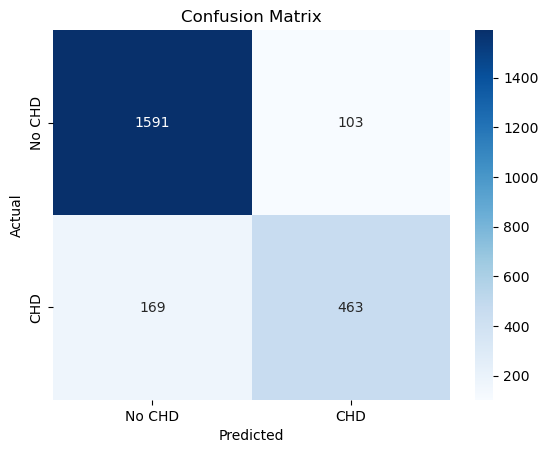

In [46]:
# calculate confusion matrix 
cm = confusion_matrix(CHD_test, CHD_prediction)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No CHD", "CHD"], yticklabels=["No CHD", "CHD"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### ROC Curve & AUC

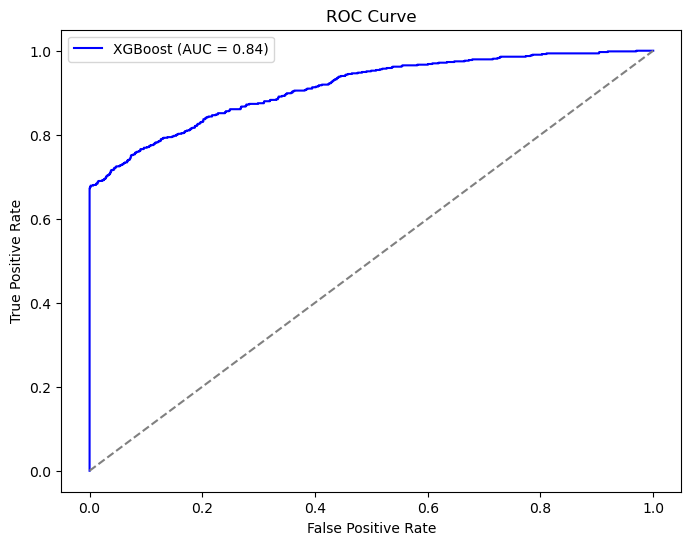

In [48]:
# Calculate ROC curve (True and False Positives) 
fpr, tpr, _ = roc_curve(CHD_test, CHD_prediction_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## **INTERACTIVE PORTION**

### Input Data Here 

In [51]:
#create ALL input fields
sex = widgets.Dropdown(options=[('Female', 0), ('Male', 1)], value=0, description='Sex:')
totchol = widgets.IntSlider(min=100, max=400, step=1, value=200, description='Tot Chol:')
age = widgets.IntSlider(min=20, max=90, step=1, value=50, description='Age:')
diabp = widgets.IntSlider(min=50, max=120, step=1, value=80, description='Diastolic BP:')
cigpday = widgets.IntSlider(min=0, max=50, step=1, value=0, description='Cigs/day:')
bmi = widgets.FloatSlider(min=15, max=50, step=0.1, value=25, description='BMI:')
diabetes = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Diabetes:')
bpmeds = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='BP Meds:')
heartrate = widgets.IntSlider(min=40, max=150, step=1, value=70, description='Heart Rate:')
educ = widgets.Dropdown(options=[('None', 1), ('Highschool', 2),('Undergraduate', 3),('Post Grad', 4)], value=2, description='Education :', layout=widgets.Layout(width='500px'), style={'description_width': 'initial'} )
prevchd = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='CHD Hist.:')
prevstrk = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Stroke Hist.:')
angina = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Angina:')
stroke = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Stroke:')
hyperten = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], value=0, description='Hypertension:')

# Display the form
display(sex, totchol, age, diabp, cigpday, bmi, diabetes, bpmeds, heartrate, educ, prevchd, prevstrk, angina, stroke, hyperten)

# Create a button
submit_button = widgets.Button(
    description='Submit',
    button_style='success',
    tooltip='Collect Values')

# Create an output area
output = widgets.Output()

# Store collected data
collected_values = None

# Define button click behavior
def on_submit_clicked(b):
    global collected_values
    with output:
        clear_output()
        # Collect  data
        collected_values = [           
            sex.value,
            totchol.value,
            age.value,
            diabp.value,
            cigpday.value,
            bmi.value,
            diabetes.value,
            bpmeds.value,
            heartrate.value,
            educ.value,
            prevchd.value,
            prevstrk.value,
            angina.value,
            stroke.value,
            hyperten.value
        ]
        
        print("Data collected successfully!")
        #print("\nCollected values:")
        #print(collected_values)

#When clicked execute function
submit_button.on_click(on_submit_clicked)

# Display submit button and output
display(submit_button)
display(output)

Dropdown(description='Sex:', options=(('Female', 0), ('Male', 1)), value=0)

IntSlider(value=200, description='Tot Chol:', max=400, min=100)

IntSlider(value=50, description='Age:', max=90, min=20)

IntSlider(value=80, description='Diastolic BP:', max=120, min=50)

IntSlider(value=0, description='Cigs/day:', max=50)

FloatSlider(value=25.0, description='BMI:', max=50.0, min=15.0)

Dropdown(description='Diabetes:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='BP Meds:', options=(('No', 0), ('Yes', 1)), value=0)

IntSlider(value=70, description='Heart Rate:', max=150, min=40)

Dropdown(description='Education :', index=1, layout=Layout(width='500px'), options=(('None', 1), ('Highschool'…

Dropdown(description='CHD Hist.:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Stroke Hist.:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Angina:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Stroke:', options=(('No', 0), ('Yes', 1)), value=0)

Dropdown(description='Hypertension:', options=(('No', 0), ('Yes', 1)), value=0)

Button(button_style='success', description='Submit', style=ButtonStyle(), tooltip='Collect Values')

Output()

### Calculating Risk 

In [55]:
#put collected in put in array
input_data = np.array([collected_values])

#probability predictions from XGBoost using collected data
prob_CHD = final_xgb.predict_proba(input_data)[0][1]  
#print(prob_CHD)

### Interpreting Risk 

In [58]:
#fx to define risk categories( low medium high )
def classify_risk(prob):
    if prob < 0.33:
        return "Low Risk"
    elif prob < 0.66:
        return "Medium Risk"
    else:
        return "High Risk"
        
#Calculate Risk Level         
risk_category = classify_risk(prob_CHD)
#print(risk_category)

## **RESULTS**

In [61]:
#print results 
#print(f"Predicted Probability of CHD within the next 10 years: {prob_CHD: .2f}")
#print(f"Risk CLassification: {risk_category}")
# Determine color based on risk category

def get_risk_color(risk):
    risk = risk.lower()
    if "low" in risk:
        return "green"
    elif "medium" in risk or "moderate" in risk:
        return "orange"
    elif "high" in risk:
        return "red"
    return "black"  # default color

risk_color = get_risk_color(risk_category)


html_output = f"""
<div style='font-size: 20px; font-weight: bold;'>
    Predicted Probability of CHD Within 10 years: {(prob_CHD *100):.2f} % <br>
    Risk Classification: <span style='color: {risk_color}'>{risk_category}</span>
</div>
"""

display(HTML(html_output))

## Results Explained

### Configure SHAP Values 

In [65]:
# Initialize SHAP Tree Explainer  -  XGBoost model
explainer = shap.Explainer(final_xgb)

#Compute SHAP 
shap_values = explainer(input_data)
#shap_values 

### Force Plot 

In [68]:
shap.initjs()  # Load JavaScript visualization
shap.force_plot(explainer.expected_value, shap_values.values, 
                feature_names=['SEX', 'TOTCHOL', 'AGE', 'DIABP', 'CIGPDAY', 'BMI', 'DIABETES',
                               'BPMEDS', 'HEARTRTE', 'educ', 'PREVCHD', 'PREVSTRK', 'ANGINA',
                               'STROKE', 'HYPERTEN'])

### Waterfall Plot 

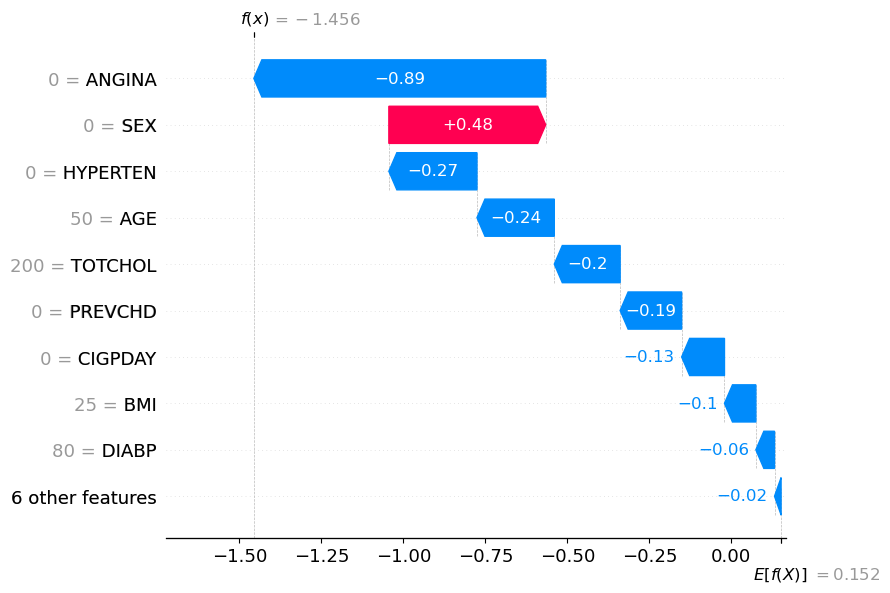

In [71]:
# Set Up Waterfall Plot
feature_names = ['SEX', 'TOTCHOL', 'AGE', 'DIABP', 'CIGPDAY', 'BMI', 'DIABETES',
                 'BPMEDS', 'HEARTRTE', 'educ', 'PREVCHD', 'PREVSTRK', 'ANGINA',
                 'STROKE', 'HYPERTEN']

# Create Data Frame with Feature Names
input_df = pd.DataFrame([[sex.value, totchol.value, age.value, diabp.value, cigpday.value,
                          bmi.value, diabetes.value, bpmeds.value, heartrate.value, educ.value,
                          prevchd.value, prevstrk.value, angina.value, stroke.value, hyperten.value]],
                        columns=feature_names)

# Compute SHAP values
shap_values = explainer(input_df)

# Generate waterfall plot with feature names
shap.plots.waterfall(shap_values[0])

### Explain Feature Importance

Feature Importance Chart 

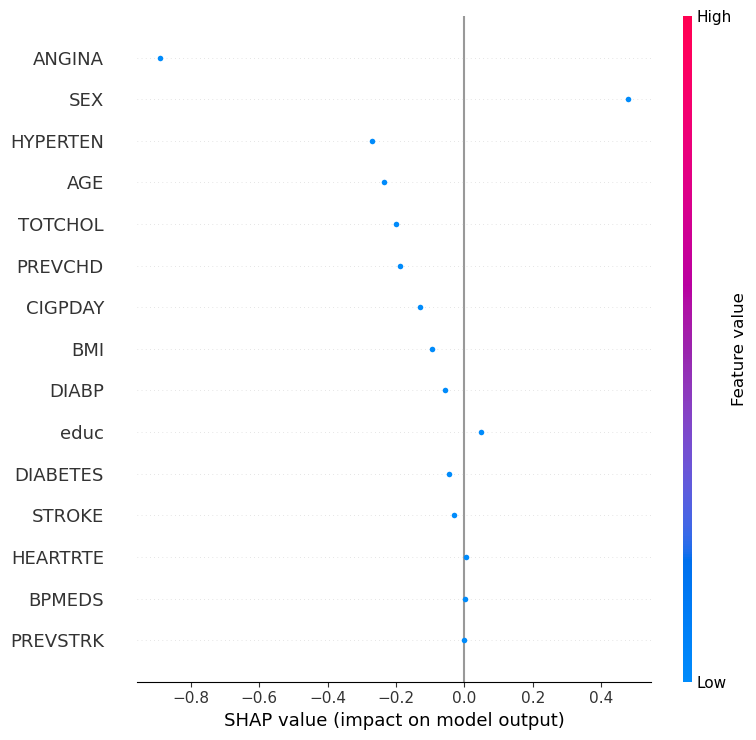

In [75]:
#insight on what features have the most impact on result
shap.summary_plot(shap_values, feature_names=['SEX', 'TOTCHOL', 'AGE', 'DIABP', 'CIGPDAY', 'BMI', 
                                              'DIABETES', 'BPMEDS', 'HEARTRTE', 'educ', 'PREVCHD', 
                                              'PREVSTRK', 'ANGINA', 'STROKE', 'HYPERTEN'])
warnings.filterwarnings('ignore')
